In [1]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

In [4]:
X = np.zeros((N*K, D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

(-1, 1)

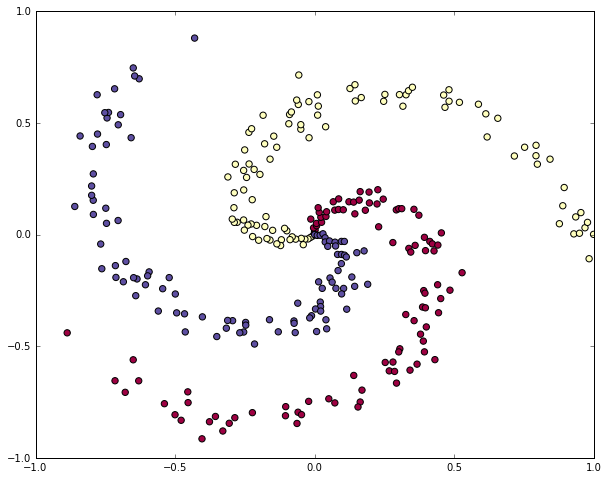

In [5]:
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

## 1-layer (linear classifyer)

In [63]:
# params
step = 1e-0
reg = 1e-3


In [64]:
n_examples = X.shape[0]

In [80]:
def _data_loss(proba, y):

    # average cross-entropy loss
    correct_proba = proba[range(len(y)),y] #(300)
    correct_proba_log = -np.log(correct_proba) #(300) -log(0.1) -> 2,3; -log(0.99) -> 0.01
    data_loss = np.sum(correct_proba_log)/len(y) # float
    return data_loss

In [74]:
def _proba(scores):
    # arr = np.array([[1,2,3],[11,22,33],[111,222,333]])
    # sum = np.sum(arr, axis=1, keepdims=True) -> 
    #  [[  3],
    #   [ 33],
    #   [333]]
    # arr / sum -> 
    # [[ 0.16666667  0.33333333  0.5       ]
    #  [ 0.16666667  0.33333333  0.5       ]
    #  [ 0.16666667  0.33333333  0.5       ]]
    exp = np.exp(scores)
    return exp/(np.sum(exp, axis=1, keepdims=True))

In [81]:
W = np.random.randn(D,K) # (2,3)
b = np.zeros((1,K)) # (1,3)

for i in range(101):
    # scores
    scores = X.dot(W) + b # (300,2) x (2,3) + (1,3) = (300,3) + (1,3) = (300,3)
    
    # proba - softmax
    proba = _proba(scores) # (300,3)
    
    # loss
    l2_loss = 0.5*reg*np.sum(W*W)
    loss = _data_loss(proba, y) + l2_loss
    if i % 10 == 0:
        print("iteration %d: loss %f" % (i, loss))
        
    # compute the gradient on scores
    dscores = proba               # (300,3) [[0.33036227   0.33697898  0.33265875]...]
    dscores[range(len(y)),y] -= 1 # (300,3) [[-0.66963773  0.33697898  0.33265875]...]
    dscores /= len(y)             # (300,3) [[-0.00223213  0.00112326  0.00110886]...]
    
    #backpropagation: applying gradient to W
    dW = X.T.dot(dscores) # (2,3) = (2,300) x (300,3)
    db = np.sum(dscores, axis=0, keepdims=True) # (1,3)
    # W:
    # [[ 0.84971166  0.81042167 -2.44953822]
    #  [-2.24167194  3.06976218 -0.31209   ]]
    # 
    # dW:
    # [[-0.00316585 -0.00236457  0.00553042]
    #  [ 0.00724266 -0.00892697  0.00168431]]
    
    dW += reg*W # regularization gradient
    
    #performing update (to the antigradient direction)
    W += -step * dW
    b += -step * db
    
    
    

iteration 0: loss 1.502778
iteration 10: loss 1.046184
iteration 20: loss 0.882064
iteration 30: loss 0.815344
iteration 40: loss 0.783598
iteration 50: loss 0.766531
iteration 60: loss 0.756515
iteration 70: loss 0.750257
iteration 80: loss 0.746162
iteration 90: loss 0.743389
iteration 100: loss 0.741460


In [76]:
#Evaluation:
scores = X.dot(W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.56


(-1.9149679951792611, 1.8650320048207423)

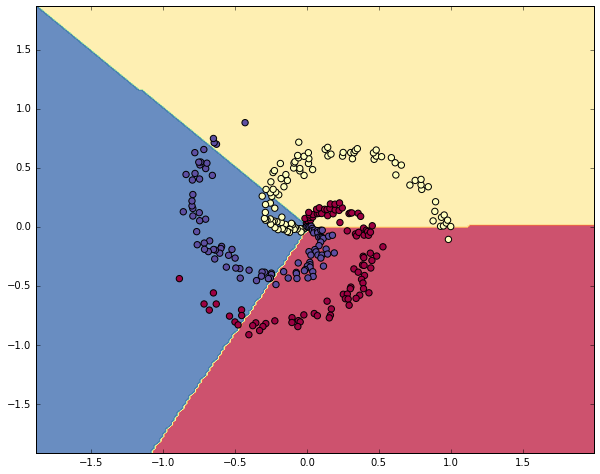

In [73]:
# Visualisation

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## 2-layer (Preceptron)


In [101]:
hid_n = 100
W1 = np.random.randn(D,hid_n) # (2,100)
b1 = np.zeros((1,hid_n))      # (1,100)
W2 = np.random.randn(hid_n,K) # (100,3)
b2 = np.zeros((1,K))      # (1,3)


for i in range(201):
    layer1 = X.dot(W1) + b1 # (300,2) x (2,100) + (1,100) = (300,100)
    hidden = np.maximum(0, layer1) # relu (300,100)
    scores = hidden.dot(W2) + b2 # (300,100) x (100,3) + (1,3) = (300,3)
    
    # answers probability (softmax)
    proba = _proba(scores) # (300, 3)
    
    #loss
    l2_loss = 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
    loss = _data_loss(proba, y) + l2_loss
    if i % 100 == 0:
        print("iteration %d: loss %f" % (i, loss))
    
    # compute the gradient on scores
    dscores = proba               
    dscores[range(len(y)),y] -= 1
    dscores /= len(y)    # (300, 3)         
    
    # Backpropation
    # 1.1 backprop: W2 and b2
    dW2 = hidden.T.dot(dscores)  # want (100,3), can use dscores & hidden:
                                 # hidden.T(100,300) x dscores(300,3) = (100,3)    
    db2 = np.sum(dscores, axis=0, keepdims=True) #      (1,3)
    # 1.2 hidden
    dhidden = dscores.dot(W2.T) # want (300,100), can use dscores & W2: 
                                # dscores(300,3) x W2.T(3,100) = (300,100)
    # backprop the ReLU non-linearity
    dhidden[hidden <= 0] = 0
    # 2 backprop W1, b1
    dW1 = X.T.dot(dhidden)  # want (2,100), can use dhidden & X:
                            # X.T(2,300) x hidden(300,100) = (2,100)
    db1 = np.sum(dhidden, axis=0, keepdims=True) #           (1,100)
    
    # Regularization
    dW1 += reg * W1
    dW2 += reg * W2

    # Perform update
    W1 += -step * dW1
    W2 += -step * dW2
    b1 += -step * db1
    b2 += -step * db2
    
    

iteration 0: loss 2.913630
iteration 100: loss 0.353488
iteration 200: loss 0.323628


In [102]:
#Evaluation:
scores = np.maximum(0, X.dot(W1) + b1).dot(W2)+b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


(-1.9149679951792611, 1.8650320048207423)

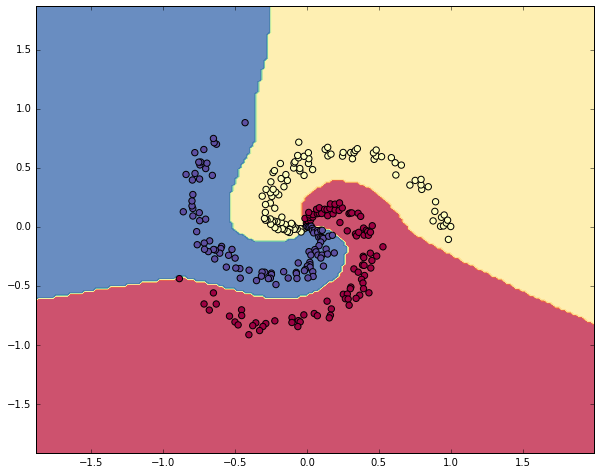

In [103]:
# Visualisation

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())